#### **Problem:** <br>
Marketing A/B Testing: Viewers are shown either an ad or public service announcement (PSA). The ad is the experimental group, and the PSA is the control group. Analyze the A/B Testing results to see if the ads were successful and viewers purchase more products and increase revenue.

#### **Dataset:** <br>
The dataset is obtained from Kaggle: https://www.kaggle.com/datasets/faviovaz/marketing-ab-testing?resource=download

#### **Methods:** <br>
1. Data Exploration
    * Check for null values
    * Check for duplicate users
    * What is the difference between the control and experimental group, in terms of group size, conversion, ads seen per person, day the person views the most ads, hour the person saw the most ads
2. Data Analysis
 * Permutation and Bootstrapping
 * Null Hypothesis (H0): There is no difference in conversion rates between the control group (PSA) and the experimental group (Ads).
 * Alternative Hypothesis (H1): There is a difference in conversion rates between the control group (PSA) and the experimental group (Ads)
 * For both the permutation and boostrapping tests, at alpha 0.05, we can reject the null hypothesis. The ads do have an effect on the conversion rate.
    
#### **Takeways:** <br>
Since A/B testing result analysis shows that ads do have an effect on the conversion rate, the company should proceed forward with showing the ad to all viewers.

In [58]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.power import NormalIndPower
from mlxtend.evaluate import permutation_test

In [59]:
#read in the data and remove index column
data = pd.read_csv("Kaggle_marketing_AB.csv")


#clean up the data. Remove the first column which is the indices. Pandas already has an index col
data = data.drop('Unnamed: 0', axis=1)

##### **1. Data Exploration** <br>
* There are 588,101 viewers
* No null values
* 96% viewers were shown ads, and 4% viewers were shown psa.
* Percentage of people converted (made a purchase) in the control group:  1.79
* Percentage of people converted(made a purchase) in the test group:  2.55

In [60]:
data.head()

,user id,test group,converted,total ads,most ads day,most ads hour
0,1069124,ad,False,130,Monday,20
1,1119715,ad,False,93,Tuesday,22
2,1144181,ad,False,21,Tuesday,18
3,1435133,ad,False,355,Tuesday,10
4,1015700,ad,False,276,Friday,14


In [61]:
#determine the number of unique user_id's
unique_id_num = data['user id'].nunique()

if unique_id_num == data.shape[0]:
  print("All user ids are unique in the dataset\n")

print("Total number of viewers: ", len(data), '\n')

#check for nans
check_nans = data.isnull().values.any()
if check_nans == False:
  print("There are no null values in the dataset\n")


#calculate the % of people in the different test groups. 96% ads and 4%psa. Use SMOTE to correct this?
print(data['test group'].value_counts())
print()
ad_perc = (data['test group'].value_counts()[0]/data.shape[0])*100
psa_perc = (data['test group'].value_counts()[1]/data.shape[0]) *100
print(f"Percentage of viewers shown ads: ", ad_perc)
print(f"Percentage of viewers shown psa: ", psa_perc)
print()



All user ids are unique in the dataset

Total number of viewers:  588101 

There are no null values in the dataset

test group
ad     564577
psa     23524
Name: count, dtype: int64

Percentage of viewers shown ads:  96.0000068015528
Percentage of viewers shown psa:  3.9999931984472057



C:\Users\yong2\AppData\Local\Temp\ipykernel_24736\1053440003.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ad_perc = (data['test group'].value_counts()[0]/data.shape[0])*100
C:\Users\yong2\AppData\Local\Temp\ipykernel_24736\1053440003.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  psa_perc = (data['test group'].value_counts()[1]/data.shape[0]) *100


In [62]:
#covert the weekdays (such as "Monday" to 1, "Tuesday"  to 2)
days_mapping_dict = { 'Monday':0, 'Tuesday':1, "Wednesday":2, "Thursday":3, "Friday":4, "Saturday":5, "Sunday":6}

data['most ads day'] = data['most ads day'].map(days_mapping_dict)

#convert the boolean "converted" col to integers, 0 and 1
data['converted'] = data['converted'].astype(int)


In [63]:
#separate the data into 2 groups, ads and psa for further EDA
control_grp = data[data['test group'] == 'psa']
test_grp = data[data['test group'] == 'ad']

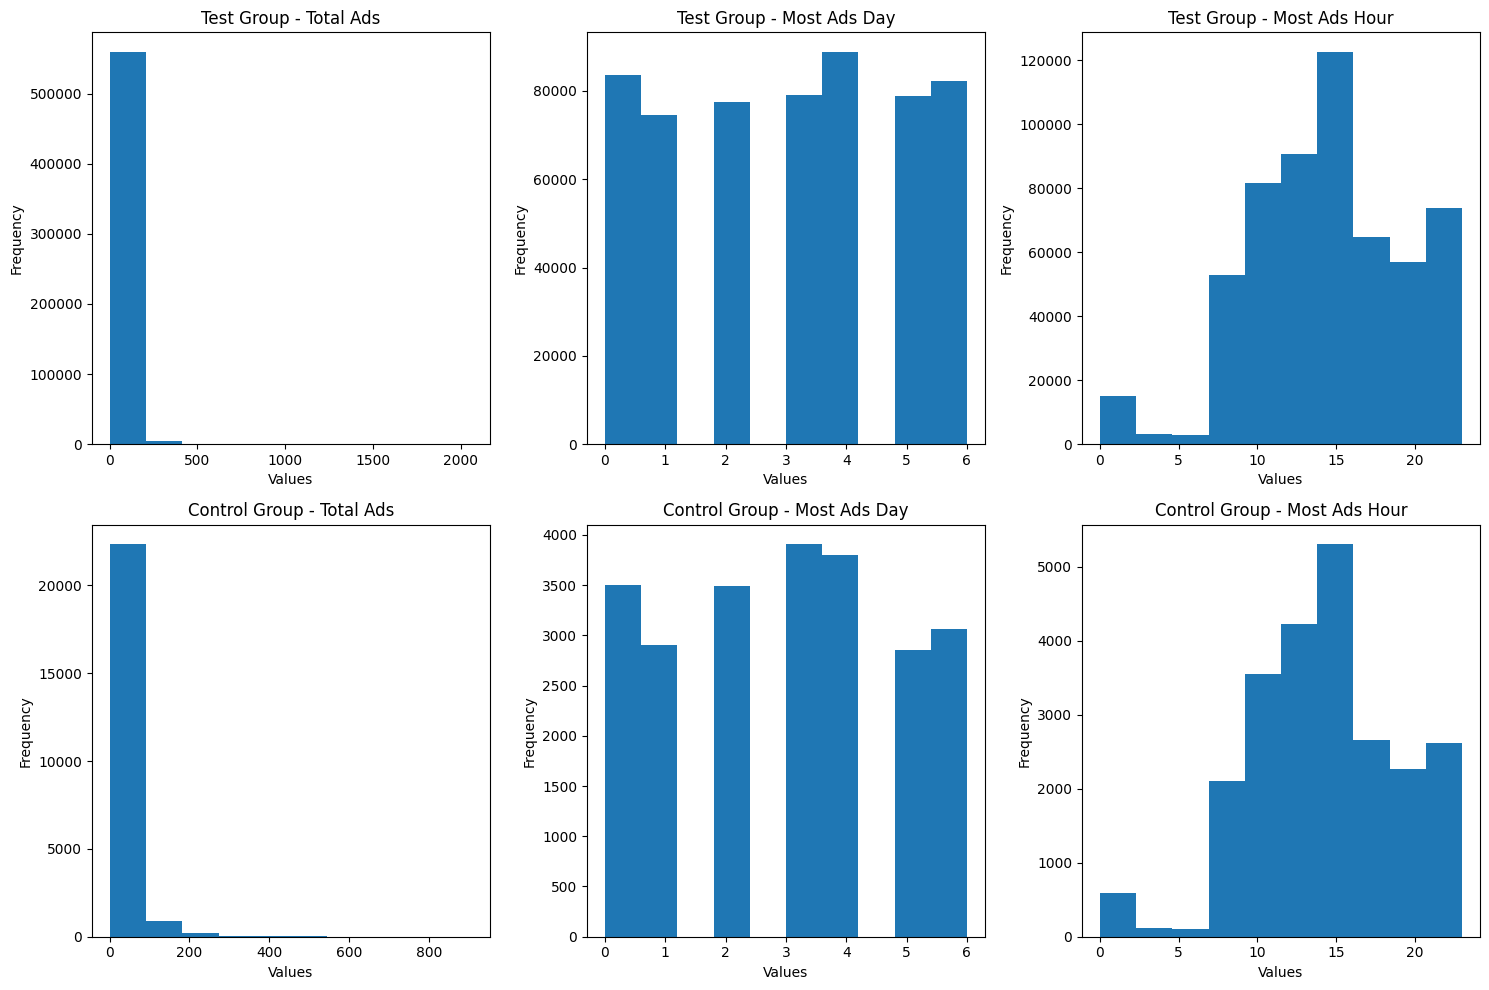

In [64]:
#explore total ads, most ads day, most ads hour for both groups
def plot_data(ax, col, title):
    ax.hist(col)  # Adjust the number of bins as needed
    ax.set_xlabel('Values')
    ax.set_ylabel('Frequency')
    ax.set_title(title)


fig, axs = plt.subplots(2, 3, figsize=(15, 10))

plot_data(axs[0, 0], test_grp['total ads'], title='Test Group - Total Ads')
plot_data(axs[0, 1], test_grp['most ads day'], title='Test Group - Most Ads Day')
plot_data(axs[0, 2], test_grp['most ads hour'], title='Test Group - Most Ads Hour')
plot_data(axs[1, 0], control_grp['total ads'], title='Control Group - Total Ads')
plot_data(axs[1, 1], control_grp['most ads day'], title='Control Group - Most Ads Day')
plot_data(axs[1, 2], control_grp['most ads hour'], title='Control Group - Most Ads Hour')

plt.tight_layout()
plt.show()


In [65]:
#percentage people who converted in the control group
ctrl_converted_perc = ((control_grp['converted'] == True).sum() /len(control_grp))*100
print("Percentage of people converted in the control group: ", round(ctrl_converted_perc,2))

#percentage people who converted in the exp group
test_converted_perc = ((test_grp['converted'] == True).sum() /len(test_grp))*100
print("Percentage of people converted in the test group: ", round(test_converted_perc,2))

conversion_diff = test_converted_perc - ctrl_converted_perc
print("Conversion difference between both groups: ", round(conversion_diff,2))


Percentage of people converted in the control group:  1.79
Percentage of people converted in the test group:  2.55
Conversion difference between both groups:  0.77


##### **2. Data Analysis** <br>
1. Determine whether the sample size is large enough for this experiment, using power analysis. <br>
The sample size would be determined before the start of the experiment. You would use the effect size (minimum amount of change you want to detect), alpha (signficance level), and power (desired statistical power) to determine the sample size. <br>
However, since I didn't design the experiment, I'm evaluating the sample size to check whether the groups are sufficiently large to identify a meaningful change. 
2. Bootstrapping to determine if there is a signficant difference in conversion between the two groups <br>
What is the probability of the experimental (ad) group being better than the control (psa) group? If that probability is higher than 95%, we assume the difference is significant.

In [66]:
#determine the sample size needed.  
power_analysis = NormalIndPower()
sample_size = power_analysis.solve_power(effect_size = 0.05, alpha = 0.05,
                                         power = 0.90, alternative = 'two-sided')
print("The calculated sample size, with a statistical power of 0.90, a significance level of 0.05, and an effect size of 0.05: ", round(sample_size))
print("Both groups have sample sizes that are adequate for detecting significant differences")

The calculated sample size, with a statistical power of 0.90, a significance level of 0.05, and an effect size of 0.05:  8406
Both groups have sample sizes that are adequate for detecting significant differences


2a. Bootstrapping

In [67]:
#bootstrapping
num_samples = 1000 #bootstrap samples

bootstrap_diffs = []

for i in range(num_samples):
    boot_control = np.random.choice(control_grp['converted'], size=len(control_grp), replace=True)
    boot_test = np.random.choice(test_grp['converted'], size=len(test_grp), replace=True)

    # Compute mean difference for the bootstrap samples
    bootstrap_diff = boot_test.mean() - boot_control.mean()

    bootstrap_diffs.append(bootstrap_diff)


In [68]:
#use the bootstrap results to determine if ads had an effect on conversion
bootstrap_diffs = np.array(bootstrap_diffs)
actual_diff = test_grp['converted'].mean() - control_grp['converted'].mean()

# Compute p-value
p_value = (np.abs(bootstrap_diffs) > np.abs(actual_diff)).mean()

print(f"Observed difference: {actual_diff:.2f}")
print(f"Bootstrap p-value: {p_value:.4f}")
print("Since alpha is 0.05, and the p-value is less than alpha (0.05), then we reject the null hypothesis that ads did not affect sales.")

Observed difference: 0.01
Bootstrap p-value: 0.4970
Since alpha is 0.05, and the p-value is less than alpha (0.05), then we reject the null hypothesis that ads did not affect sales.


2b. Permutation <br>
Another method to analyze A/B testing results is to use random permuations to see whether two samples are drawn from the same underlying categorial distribution. Both permutation and boostrap are non-parametric methods and do not make assumptions about the distribution of the data. <br>

In [72]:
test_series = test_grp['converted']
ctrl_series = control_grp['converted']
p_value = permutation_test(ctrl_series, test_series,
                           method='approximate',
                           num_rounds=1000,
                           seed=0)


In [74]:
#analyze permuation results
print("Permutation p-value is: ", p_value)
print("p-value < alpha (0.05), so we reject the null hypothesis that the two samples come from the same distribution.")

Permutation p-value is:  0.000999000999000999
p-value < alpha (0.05), so we reject the null hypothesis that the two samples come from the same distribution.
